<a href="https://colab.research.google.com/github/jamescavanagh/unpackAI/blob/main/DL201/Chapter_05_pet_breeds_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Image Classification - Own Code

Lesson 4 video from time 1:09:40 to the end and

Lesson 6 video from time 0:00:00 to 0:30:45   (skip lesson 4 video on ethics)

Own refactored code and notes for Chapter 5: *Pet Breeds with Assignments* (['05_pet_breads.ipynb'](https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/05_pet_breeds_w_assignments.ipynb#scrollTo=qyx684frVK78))

Refactor the code for the Image Classifier "Cats and Dogs" 

Rewrite the code for the image classifier that identifies Cats and Dogs; or, use your own data set that you have used before.
- Only use the code necessary to load the data, create tbe DataLoaders, presize and or augment the images and then train the model using all the knowledge and tools you have learned from the book so far adding the new nowledge you have gained in this chapter.
- Feel free to add any code that you perfer to use and make a note in the code as to why you perferred to use that code
- Add your own comments that can be used for reference in the future.

#Questionaire

##Chapter 5 Notebook

###Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
Presizing is important because Data augmentation is often done on the GPU, however, it can lead to destruction of the images and artifacts near the edges. Therefore, to minimize data destruction, the augmentations should be done on a larger image, and then do a random resize crop to the final image


###What are the two ways in which data is most commonly provided, for most deep learning datasets?
In individual files which represent items of data
A table in CSV format, where each row contains metadata along with a file path that leads to a text document or images


###Give two examples of ways that image transformations can degrade the quality of the data.
Rotation near the edge of an image can lead to blank areas in the final image. 
Interpolation may lead to diffefent


###What method does fastai provide to view the data in a DataLoaders?
DataLoader.show_batch


###What method does fastai provide to help you debug a DataBlock?
DataLoader.summary 


###What are the two pieces that are combined into cross-entropy loss in PyTorch?
Softmax function and a Negative Log Likelihood Loss


###What are the two properties of activations that softmax ensures? Why is this important?
It ensures that the output of the classes adds up to one so that the model can make only one prediction. It will take the label with the highest confidence and amplify it so that it gets picked out from the rest 



###What are two good rules of thumb for picking a learning rate from the learning rate finder?
Pick the minimum, or where the derivative is the steepest which translates to when the learning rate is approaching a minimum most rapidly. It depends on the shape of the graph however, since there can be random spikes in the graph that could have the steepest slope. 

##What two steps does the fine_tune method do?
Fine tune freezes and untrains the model



### Imports and setup

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 7.9MB/s 
     |████████████████████████████████| 1.2MB 38.2MB/s 
     |████████████████████████████████| 194kB 54.6MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
Mounted at /content/gdrive


### Preparing the data

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
Path.BASE_PATH = path
path.ls()
(path/"images").ls()



(#7393) [Path('images/wheaten_terrier_75.jpg'),Path('images/wheaten_terrier_154.jpg'),Path('images/Ragdoll_124.jpg'),Path('images/staffordshire_bull_terrier_26.jpg'),Path('images/boxer_3.jpg'),Path('images/British_Shorthair_47.jpg'),Path('images/wheaten_terrier_165.jpg'),Path('images/samoyed_30.jpg'),Path('images/Maine_Coon_131.jpg'),Path('images/saint_bernard_193.jpg')...]

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.547667,0.342818,0.112314,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.486070,0.324338,0.100135,01:04
1,0.314140,0.225221,0.075101,01:04


### Optimising and improving the model

In [ ]:
x,y = dls.one_batch()
dls.vocab


['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

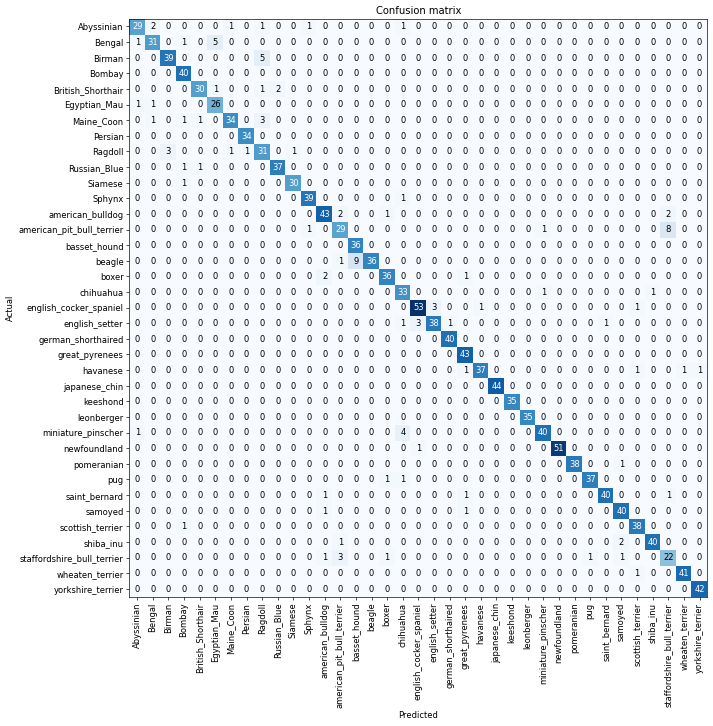

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)


[('beagle', 'basset_hound', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Birman', 'Ragdoll', 5)]

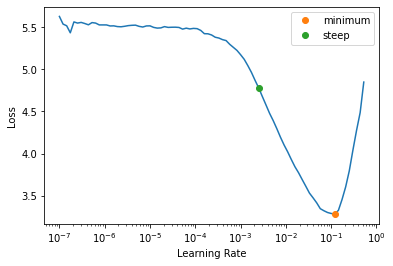

In [ ]:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")


Minimum/10: 1.20e-02, steepest point: 2.51e-03


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 1.2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.567090,0.309957,0.103518,01:02
1,0.642813,0.238627,0.076455,01:02
2,0.399529,0.223108,0.065629,01:02


SuggestedLRs(minimum=1.584893179824576e-05, steep=1.0964781722577754e-06)

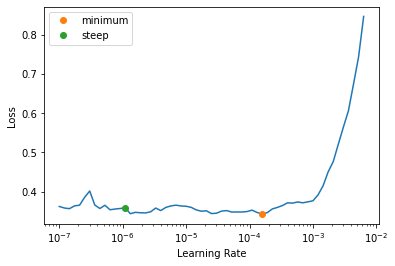

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
learn.fit_one_cycle(6, lr_max=1.05e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.349325,0.219838,0.068336,01:05
1,0.317730,0.213459,0.064276,01:05
2,0.296737,0.208217,0.066982,01:04
3,0.267758,0.203908,0.063599,01:05
4,0.249452,0.198505,0.058187,01:05
5,0.241351,0.201248,0.060893,01:04


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fab69bd50e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fab69bd50e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.140424,0.317997,0.102165,01:02
1,0.546891,0.273480,0.092693,01:02
2,0.330583,0.213868,0.070365,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.250284,0.207079,0.070365,01:04
1,0.251141,0.205151,0.068336,01:04
2,0.224678,0.191208,0.064276,01:05
3,0.199621,0.185934,0.063599,01:04
4,0.196179,0.187451,0.063599,01:04


Bull terries confused from eachother, 



### Training the Model

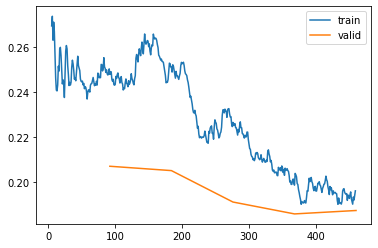

In [ ]:
learn.recorder.plot_loss()

###Evaluate the results and test the model

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.242931,0.281946,0.098106,01:05
1,0.612999,0.305609,0.106901,01:05
2,0.448136,0.250561,0.075778,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.286356,0.223241,0.075101,01:07
1,0.316903,0.299923,0.095399,01:07
2,0.248640,0.315766,0.096752,01:07
3,0.149392,0.246243,0.065629,01:07
4,0.081935,0.203819,0.058187,01:07
5,0.050408,0.205932,0.053451,01:07
